# ViT from scratch

## Overview

Main Components:
- Patch + Position Embedding
    - Linear projection: patch turned into a learnable embedding
- Layer Norm: regularizing per layer distribution (over activations per hidden unit in a layer)
- Transformer Encoder
    - Multi-head self attention (MSA)
    - MLP + GELU
- MLP Classifer Head


## Main Equations

\begin{align}
\mathbf{z}_0 &= [\mathbf{x}_{\text{class}}; \mathbf{x}_p^1 \mathbf{E}; \mathbf{x}_p^2 \mathbf{E}; \cdots; \mathbf{x}_p^N \mathbf{E}] + \mathbf{E}_{\text{pos}}, 
& \mathbf{E} \in \mathbb{R}^{(P^2 \cdot C) \times D},\ \mathbf{E}_{\text{pos}} \in \mathbb{R}^{(N+1)\times D} \tag{1} \\
\mathbf{z}'_\ell &= \text{MSA}(\text{LN}(\mathbf{z}_{\ell-1})) + \mathbf{z}_{\ell-1}, 
& \ell = 1 \ldots L \tag{2} \\
\mathbf{z}_\ell &= \text{MLP}(\text{LN}(\mathbf{z}'_\ell)) + \mathbf{z}'_\ell, 
& \ell = 1 \ldots L \tag{3} \\
\mathbf{y} &= \text{LN}(\mathbf{z}_L^0) \tag{4}
\end{align}


> Eq 1: Transformer keeps constant latent vector size D. Flatten patches to D dimensions with a trainable linear projection. Add class embedding and positional embedding (Patch Embeddings + Position Embeddings).  

* $\displaystyle \mathbf{z}_{0}$ is “z zero” (this is the output of the initial patch embedding layer).
- `E*x` = Embedding * image patch (linear projection to flatten patches)

> Eq 2 / 3: LN + MSA + LN + MLP + Residual Connection  

- $l$ is layer is for some Transformer encoder block layer
* $\displaystyle \mathbf{z}_{\ell}^{\prime}$ is “z of a particular layer prime” (an intermediary value of $\mathbf{z}$ after MSA).

* $\displaystyle \mathbf{z}_{\ell}$ is “z of a particular layer.” (output after MLP)

> Eq 4: Extract classification token (gets global attention from all patches)  

* And $\displaystyle \mathbf{y}$ is the output logits of the architecture.

![alt text](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png)

## Eq 1. Patch Embeddings

$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$

- E is for patch and position embeddings
- N is # of patches
- D is # of input dims to encoder (E is linear projection to D)
- P is patch dim. and C is # of channels

`x_input = [class_token, image_patch_1, ...] + [class_token_position. image_patch_1_position, ...]`

## Eq 2. MSA

$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

`x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input`
- layer norm and MSA input then add original input for residual connection
- $l$ is the encoder layer we are at (1 to $L$)

## Eq 3. MLP

$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\ \end{aligned} $$

- same as (2) but with a MLP

## Eq 4. Classification token

$$ \begin{aligned} \mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & & \end{aligned} $$


y = Linear_layer(LN_layer(x_output_MLP_block[0]))

ViT Base:
- layers: 12
- hidden size (D): 768 (Embedding dimension for QKV and linear projection)
- MLP size: 3072
- Heads: 12 (for Multi-head)
- total params: 86M

In [1]:
# import common scripts and functions
import sys
sys.path.append('../lib')
import data_setup, engine, helper_functions, utils

In [77]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.optim import Adam
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Hyperparams

In [72]:
# Hyperparameters

IMG_SIZE = 224
BATCH_SIZE = 32 # 4096 in the paper
HEIGHT, WIDTH = 224, 224 # (H, W)
IN_CHANNELS = 3 # (C)
PATCH_SIZE = 16 # (P)
NUM_OF_PATCHES = (HEIGHT * WIDTH) // PATCH_SIZE**2 # (N)
EMBEDDING_SIZE = PATCH_SIZE**2 * IN_CHANNELS # (D)
# 768 -> (N, P**2 * C) 
MLP_SIZE = 3072
HEADS = 12
NUM_OF_ENCODER_LAYERS = 12
MLP_DROPOUT = 0.1
EMBEDDING_DROPOUT = 0.1


# num of patches -> 196 (N) -> (H * W) / P**2

assert HEIGHT % PATCH_SIZE == 0 and WIDTH % PATCH_SIZE == 0, "Patch size doesn't evenly divide image dims"

## Load sample image

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = helper_functions.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
train_dir = str(image_path) + "/train"
test_dir = str(image_path) + "/test"

train_dir, test_dir

('data/pizza_steak_sushi/train', 'data/pizza_steak_sushi/test')

In [7]:
# Transforms
manual_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [8]:
# Dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f30c9cf7640>,
 ['pizza', 'steak', 'sushi'])

In [25]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label.item()

(torch.Size([3, 224, 224]), 1)

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

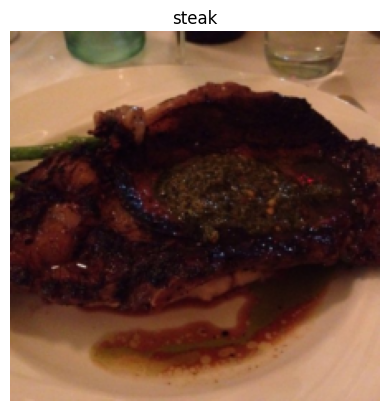

In [10]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

# Eq 1 - Patch Embedding

$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$


## Linear Projection

To practice each step, we will run a single sample image and perform tensor operations to simulate each step in each equation. Also, we want to make sure shape sizes match.

### Visual representation of patches

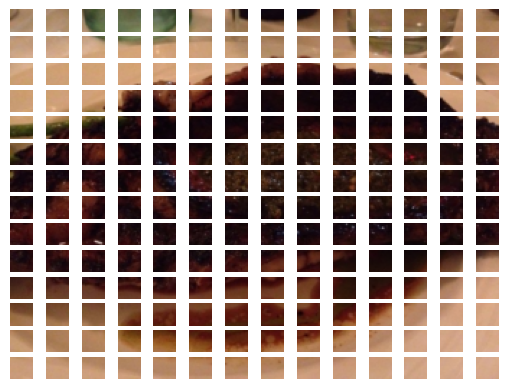

In [17]:
permuted_image = image.permute(1,2,0) # (H, W, C) for matplot

# Create a series of subplots
fig, axs = plt.subplots(nrows=IMG_SIZE // PATCH_SIZE,
                        ncols=IMG_SIZE // PATCH_SIZE)

for i, patch_height in enumerate(range(0, HEIGHT, PATCH_SIZE)):
    for j, patch_width in enumerate(range(0, WIDTH, PATCH_SIZE)):
        axs[i, j].imshow(permuted_image[patch_height:patch_height+PATCH_SIZE,
                                        patch_width:patch_width+PATCH_SIZE,
                                        :])
        axs[i, j].axis('off')
        # print(HEIGHT, PATCH_SIZE, i, j)


### Patchify Code (step by step)

In [26]:
image = image.unsqueeze(dim=0)
image.shape

torch.Size([1, 3, 224, 224])

In [ ]:
# use Conv2D to linearly project to embedding space (D)
# equivalent of using a nn.Linear(IN_CHANNELS, EMBEDDING_SIZE)
# AKA linear projecting each patch (N) to embedding space and restructuring as N embeddings of dim D
linear_projection = nn.Conv2d(in_channels=3, 
                       out_channels=EMBEDDING_SIZE, 
                       kernel_size=PATCH_SIZE,
                       stride=PATCH_SIZE)
projected_image = linear_projection(image)
projected_image.shape

torch.Size([1, 768, 14, 14])

In [29]:
# flatten patches and reorder
embedding = nn.Flatten(start_dim=2, end_dim=3)(projected_image)
embedding = embedding.permute(0, 2, 1)
embedding.shape # (B, N, D), where B is batch size

torch.Size([1, 196, 768])

## Class Token + Positional Embedding

In [30]:
# add class token
class_token = torch.ones(1, 1, 768) # use randn, using ones for demo purposes
embedding_and_class_token = torch.concat((class_token, embedding), dim=1)
embedding_and_class_token.shape, embedding_and_class_token[:, :5, :5]

(torch.Size([1, 197, 768]),
 tensor([[[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
          [ 0.1620, -0.3821, -0.0628, -0.2924, -0.3102],
          [ 0.0496, -0.3825, -0.0349, -0.1196, -0.0762],
          [ 0.0633, -0.4769, -0.0414, -0.2117, -0.1870],
          [ 0.0632, -0.4266, -0.0509, -0.1961, -0.1659]]],
        grad_fn=<SliceBackward0>))

In [34]:
# add positional embedding
positional_embedding = torch.ones(1, NUM_OF_PATCHES + 1, EMBEDDING_SIZE)
print(positional_embedding.shape)
patch_embedding = embedding_and_class_token + positional_embedding
patch_embedding.shape

torch.Size([1, 197, 768])


torch.Size([1, 197, 768])

### Putting it all together!

In [41]:
class PatchEmbedding(nn.Module):
    """Patch Embedding layer

    1. Linear projects to embedding space
    2. Appends Class Token
    3. Adds Positional Embedding
    
    """

    def __init__(self, HEIGHT, WIDTH, IN_CHANNELS, PATCH_SIZE):
        super().__init__()
        
        assert HEIGHT % PATCH_SIZE == 0 and WIDTH % PATCH_SIZE == 0, "Patch size doesn't evenly divide image dims"

        self.num_of_patches = (HEIGHT * WIDTH) // PATCH_SIZE**2 # N
        self.embedding_size = PATCH_SIZE**2 * IN_CHANNELS # D

        self.linear_projection = nn.Conv2d(in_channels=3, 
                                            out_channels=self.embedding_size, 
                                            kernel_size=PATCH_SIZE, # P
                                            stride=PATCH_SIZE) # P
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    
    def forward(self, x): # (B, H, W, C)

        B = x.shape[0]
        # learnable tensors
        class_token = nn.Parameter(torch.randn(B, 1, 768),
                                   requires_grad=True)
        positional_embedding = nn.Parameter(torch.rand(B, self.num_of_patches + 1, self.embedding_size),
                                                       requires_grad=True)

        # linear projection
        projection = self.linear_projection(x) # B, D, P, P
        flattened = self.flatten(projection) 
        flattened = flattened.permute(0, 2, 1) # B, N, D

        # concat class token
        torch.concat((class_token, flattened), dim=1) # B, N + 1, D

        # add positional embedding
        patch_embedding = embedding_and_class_token + positional_embedding # B, N + 1, D

        return patch_embedding # B, N + 1, D

PatchEmbedding(HEIGHT, WIDTH, IN_CHANNELS, PATCH_SIZE)(image).shape


torch.Size([1, 197, 768])

# Eq 2. MSA

$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

In [45]:
patch_embedding = PatchEmbedding(HEIGHT, WIDTH, IN_CHANNELS, PATCH_SIZE)(image)
patch_embedding.shape

torch.Size([1, 197, 768])

In [47]:
# LN
ln = nn.LayerNorm(normalized_shape=EMBEDDING_SIZE)
ln_patch_embedding = ln(patch_embedding)
patch_embedding.shape

torch.Size([1, 197, 768])

In [50]:
# MSA
msa = nn.MultiheadAttention(EMBEDDING_SIZE, HEADS, dropout=0)
msa_patch_embedding, _ = msa(ln_patch_embedding, ln_patch_embedding, ln_patch_embedding) # Q, K, V same for self attention
msa_patch_embedding.shape

torch.Size([1, 197, 768])

In [52]:
# Residual Connection
msa_output = msa_patch_embedding + patch_embedding
msa_output.shape

torch.Size([1, 197, 768])

In [57]:
class MSA_Block(nn.Module):

    def __init__(self, EMBEDDING_SIZE, NUM_OF_HEADS, DROPOUT):
        super().__init__()
        self.ln = nn.LayerNorm(normalized_shape=EMBEDDING_SIZE)
        self.msa = nn.MultiheadAttention(EMBEDDING_SIZE, NUM_OF_HEADS, DROPOUT, batch_first=True)

    def forward(self, x):
        x = self.ln(x)
        attn_output, _ = self.msa(x, x, x)
        return attn_output # omit residual for Encoder block
    
msa_output = MSA_Block(EMBEDDING_SIZE, HEADS, 0)(patch_embedding) + patch_embedding
msa_output.shape

torch.Size([1, 197, 768])

# Eq 3. MLP

$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\ \end{aligned} $$

In [62]:
class MLP_Block(nn.Module):

    def __init__(self, EMBEDDING_SIZE, MLP_SIZE, MLP_DROPOUT):
        super().__init__()
        self.ln = nn.LayerNorm(EMBEDDING_SIZE)
        self.mlp = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, MLP_SIZE),
            nn.GELU(),
            nn.Dropout(MLP_DROPOUT),
            nn.Linear(MLP_SIZE, EMBEDDING_SIZE),
            nn.Dropout(MLP_DROPOUT)
        )

    def forward(self, x):
        return self.mlp(self.ln(x))

mlp_output = MLP_Block(EMBEDDING_SIZE, MLP_SIZE, MLP_DROPOUT)(msa_output) + msa_output
mlp_output.shape

torch.Size([1, 197, 768])

## Transformer Encoder (combining Eq 2 and 3)

In [65]:
class Transformer_Encoder_Block(nn.Module):

    def __init__(self, EMBEDDING_SIZE, NUM_OF_HEADS, MLP_SIZE, MLP_DROPOUT, ATTN_DROPOUT=0):
        super().__init__()

        # eq 2
        self.msa_block = MSA_Block(EMBEDDING_SIZE, NUM_OF_HEADS, ATTN_DROPOUT)
        
        # eq 3
        self.mlp_block = MLP_Block(EMBEDDING_SIZE, MLP_SIZE, MLP_DROPOUT)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

block_output = Transformer_Encoder_Block(EMBEDDING_SIZE, HEADS, MLP_SIZE, MLP_DROPOUT, 0)(patch_embedding)
block_output.shape

torch.Size([1, 197, 768])

# Eq 4. Class token extraction

$$ \begin{aligned} \mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & & \end{aligned} $$


In [67]:
nn.LayerNorm(normalized_shape=EMBEDDING_SIZE)(block_output[:, 0, :]).shape # LN(class token)

torch.Size([1, 768])

# ViT all together!

\begin{align}
\mathbf{z}_0 &= [\mathbf{x}_{\text{class}}; \mathbf{x}_p^1 \mathbf{E}; \mathbf{x}_p^2 \mathbf{E}; \cdots; \mathbf{x}_p^N \mathbf{E}] + \mathbf{E}_{\text{pos}}, 
& \mathbf{E} \in \mathbb{R}^{(P^2 \cdot C) \times D},\ \mathbf{E}_{\text{pos}} \in \mathbb{R}^{(N+1)\times D} \tag{1} \\
\mathbf{z}'_\ell &= \text{MSA}(\text{LN}(\mathbf{z}_{\ell-1})) + \mathbf{z}_{\ell-1}, 
& \ell = 1 \ldots L \tag{2} \\
\mathbf{z}_\ell &= \text{MLP}(\text{LN}(\mathbf{z}'_\ell)) + \mathbf{z}'_\ell, 
& \ell = 1 \ldots L \tag{3} \\
\mathbf{y} &= \text{LN}(\mathbf{z}_L^0) \tag{4}
\end{align}


In [75]:
class MyViT(nn.Module):

    def __init__(self, HEIGHT, WIDTH, IN_CHANNELS, EMBEDDING_DROPOUT, PATCH_SIZE, NUM_OF_HEADS,
                 NUM_OF_ENCODER_LAYERS, MLP_SIZE, MLP_DROPOUT, NUM_OF_CLASSES, ATTN_DROPOUT = 0):
        super().__init__()
        self.NUM_OF_PATCHES = (HEIGHT * WIDTH) // PATCH_SIZE**2 # (N)
        self.EMBEDDING_SIZE = PATCH_SIZE**2 * IN_CHANNELS # (D)
        assert HEIGHT % PATCH_SIZE == 0 and WIDTH % PATCH_SIZE == 0, "Patch size doesn't evenly divide image dims"

        # Eq. 1
        self.patch_embedding = PatchEmbedding(HEIGHT, WIDTH, IN_CHANNELS, PATCH_SIZE)
        self.embedding_dropout = nn.Dropout(EMBEDDING_DROPOUT)

        # Eq. 2 and 3
        self.encoder = nn.Sequential(
            *[Transformer_Encoder_Block(EMBEDDING_SIZE, NUM_OF_HEADS, MLP_SIZE, MLP_DROPOUT, ATTN_DROPOUT) 
              for _ in range(NUM_OF_ENCODER_LAYERS)]
        )
        
        # classifier head (Eq. 4)
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=EMBEDDING_SIZE),
            nn.Linear(EMBEDDING_SIZE, NUM_OF_CLASSES)
        )

    def forward(self, x): # B, C, H, W
        
        x = self.patch_embedding(x) # B, N+1, D
        x = self.embedding_dropout(x)
        x = self.encoder(x) # B, N+1, D
        x = self.classifier(x[:, 0]) # B, 1, D
        return x

In [76]:
vit = MyViT(HEIGHT, WIDTH, IN_CHANNELS, EMBEDDING_DROPOUT, PATCH_SIZE, HEADS,
            NUM_OF_ENCODER_LAYERS, MLP_SIZE, MLP_DROPOUT, len(class_names))
vit(image)

tensor([[-0.0878,  0.1110, -0.0204]], grad_fn=<AddmmBackward0>)

In [ ]:
summary(model=vit, input_size=(32, 3, 224, 224))